<a href="https://colab.research.google.com/github/nikitakor7/LMM_basics/blob/main/Generating_AutoBlogPost_using_AI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

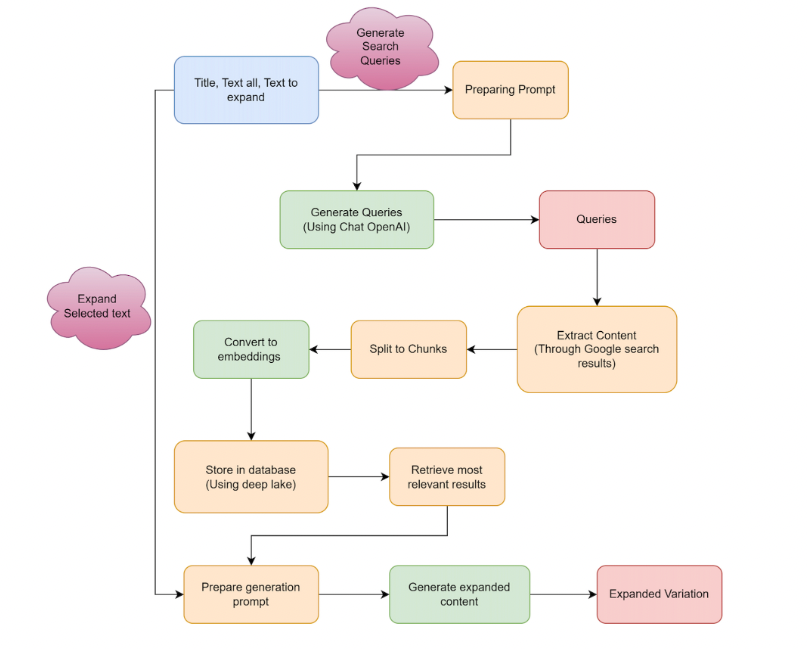

In [ ]:
!pip install -q langchain==0.0.208 openai==0.27.8 tiktoken newspaper3k

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 939.3/939.3 kB 28.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.1/211.1 kB 13.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.0/90.0 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.1/81.1 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.3/93.3 kB 3.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 29.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 12.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 26.5 MB/s eta 0:00

In [ ]:
# let's setup the keys

import os

os.environ["GOOGLE_CSE_ID"] = "<GOOGLE_CSE_ID>"
os.environ["GOOGLE_API_KEY"] = "<GOOGLE_API_KEY>"
os.environ["OPENAI_API_KEY"] = "<OPENAI_API_KEY>"

In [ ]:
url = "https://www.artificialintelligence-news.com/2023/05/16/openai-ceo-ai-regulation-is-essential/"

title = "OpenAI CEO: AI regulation ‘is essential’"

text_all = """Altman highlighted the potential benefits of AI technologies like ChatGPT and Dall-E 2 to help address significant challenges such as climate change and cancer, but he also stressed the need to mitigate the risks associated with increasingly powerful AI models.

Altman proposed that governments consider implementing licensing and testing requirements for AI models that surpass a certain threshold of capabilities. He highlighted OpenAI’s commitment to safety and extensive testing before releasing any new systems, emphasising the company’s belief that ensuring the safety of AI is crucial.

Senators Josh Hawley and Richard Blumenthal expressed their recognition of the transformative nature of AI and the need to understand its implications for elections, jobs, and security. Blumenthal played an audio introduction using an AI voice cloning software trained on his speeches, demonstrating the potential of the technology.

Blumenthal raised concerns about various risks associated with AI, including deepfakes, weaponised disinformation, discrimination, harassment, and impersonation fraud. He also emphasised the potential displacement of workers in the face of a new industrial revolution driven by AI."""

text_to_change = """Senators Josh Hawley and Richard Blumenthal expressed their recognition of the transformative nature of AI and the need to understand its implications for elections, jobs, and security. Blumenthal played an audio introduction using an AI voice cloning software trained on his speeches, demonstrating the potential of the technology."""

In [ ]:
from langchain.chat_models import ChatOpenAI
from langchain.chains import LLMChain
from langchain.prompts import PromptTemplate
from langchain.prompts.chat import (
    ChatPromptTemplate,
    HumanMessagePromptTemplate,
)

template = """You are an exceptional copywriter and content creator.

You're reading an article with the following title:
----------------
{title}
----------------

You've just read the following piece of text from that article.
----------------
{text_all}
----------------

Inside that text, there's the following TEXT TO CONSIDER that you want to enrich with new details.
----------------
{text_to_change}
----------------

What are some simple and high-level Google queries that you'd do to search for more info to add to that paragraph?
Write 3 queries as a bullet point list, prepending each line with -.
"""

human_message_prompt = HumanMessagePromptTemplate(
    prompt=PromptTemplate(
        template=template,
        input_variables=["text_to_change", "text_all", "title"],
    )
)

chat_prompt_template = ChatPromptTemplate.from_messages([human_message_prompt])
chat = ChatOpenAI(temperature=0.9)
chain = LLMChain(llm=chat, prompt=chat_prompt_template)
response = chain.run({
    "text_to_change": text_to_change,
    "text_all": text_all,
    "title": title
})
queries = [line[2:] for line in response.split("\n")]
print(queries)

['"AI implications for elections"', '"AI job displacement"', '"AI security risks"']


In [ ]:
# first, we create a tool that allows us to use Google search.
# we'll use it to retrieve the first 10 results

from langchain.tools import Tool
from langchain.utilities import GoogleSearchAPIWrapper

search = GoogleSearchAPIWrapper()
TOP_N_RESULTS = 5

def top_n_results(query):
    return search.results(query, TOP_N_RESULTS)

tool = Tool(
    name = "Google Search",
    description="Search Google for recent results.",
    func=top_n_results
)

In [ ]:
# this is how we can use the tool. For each result, we have:
# 1. the result title
# 2. its URL
# 3. and the snippet that we would see if we were on the Google UI

all_results = []

for query in queries:
    results = tool.run(query)
    all_results += results

    if "title" in results[0]: # Sample
        print(results[0]["title"])
        print(results[0]["link"])
        print(results[0]["snippet"])
        print("-"*50)

Job Displacement - AI SUPERPOWERS new book by Kai-Fu Lee of ...
https://www.aisuperpowers.com/job-displacement
AI Job Displacement Index. How will your job be affected by AI? Within the next fifteen years, AI and automation will be able to do virtually all basic work ...
--------------------------------------------------
OWASP AI Security and Privacy Guide | OWASP Foundation
https://owasp.org/www-project-ai-security-and-privacy-guide/
Feb 15, 2023 ... Particular AI security risks · Data Security Risks: · AI model attacks, or adversarial machine learning attacks represent important security risks ...
--------------------------------------------------


In [ ]:
# let's visit all the URLs from the results and use the newspaper library
# to download their texts. The library won't work on some URLs, e.g.
# if the content is a PDF file or if the website has some anti-bot mechanisms
# adopted.

import newspaper

pages_content = []

for result in all_results:
    try:
        article = newspaper.Article(result["link"])
        article.download()
        article.parse()
        if len(article.text) > 0:
            pages_content.append({ "url": result["link"], "text": article.text })
    except:
        continue

print("Number of pages: ", len(pages_content))

Number of pages:  10


In [ ]:
# we split the article texts into small chunks. While doing so, we keep track of each
# chunk metadata (i.e. the URL where it comes from). Each metadata is a dictionary and
# we need to use the "source" key for the document source so that the chain
# that we'll create later knows where to retrieve the source.

from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.docstore.document import Document

text_splitter = RecursiveCharacterTextSplitter(chunk_size=3000, chunk_overlap=100)

docs = []
for d in pages_content:
    chunks = text_splitter.split_text(d["text"])
    for chunk in chunks:
        new_doc = Document(page_content=chunk, metadata={ "source": d["url"] })
        docs.append(new_doc)

print("Number of chunks: ", len(docs))

Number of chunks:  26


In [ ]:
# then, we embed both the chunks and the query

from langchain.embeddings import OpenAIEmbeddings

embeddings = OpenAIEmbeddings(model="text-embedding-ada-002")

docs_embeddings = embeddings.embed_documents([doc.page_content for doc in docs])
query_embedding = embeddings.embed_query(text_to_change)

In [ ]:
# next, we compute the cosine similarities between the document vectors and
# the query vectors using numpy and sklearn. We are interested only in the top 3
# chunks for now because we'll later put them in a prompt and the prompt size is
# limited.

import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

def get_top_k_indices(list_of_doc_vectors, query_vector, top_k):
    # convert the lists of vectors to numpy arrays
    list_of_doc_vectors = np.array(list_of_doc_vectors)
    query_vector = np.array(query_vector)

    # compute cosine similarities
    similarities = cosine_similarity(query_vector.reshape(1, -1), list_of_doc_vectors).flatten()

    # sort the vectors based on cosine similarity
    sorted_indices = np.argsort(similarities)[::-1]

    # retrieve the top K indices from the sorted list
    top_k_indices = sorted_indices[:top_k]

    return top_k_indices

top_k = 3
best_indexes = get_top_k_indices(docs_embeddings, query_embedding, top_k)
best_k_documents = [doc for i, doc in enumerate(docs) if i in best_indexes]

In [ ]:
best_k_documents

[Document(page_content='How to Prepare for AI Job Displacement Kai-Fu Lee · Follow · Oct 25, 2018 3 min read -- 1 Listen Share\n\nAs individuals, we should accept that routine jobs are going away. For young people in these routine jobs, start now by finding careers that fit your strengths and that are not easily replaced by AI. For older people, when early retirement is offered to you, consider accepting, with gig economy and volunteering to make some income and live a life you enjoy.\n\nWe should encourage more people to go into service careers, choosing jobs into which they can pour their hearts and souls, spreading their love and experiences.\n\nWe should embrace AI tools, especially for professionals, understanding that they will get better with more data and use. We should use these tools to do parts of our jobs, allowing them to do more of our routine tasks, freeing us to move into areas that are more suitable for humans.\n\nWe should encourage all kinds of creativity beyond the 

In [ ]:
template = """You are an exceptional copywriter and content creator.

You're reading an article with the following title:
----------------
{title}
----------------

You've just read the following piece of text from that article.
----------------
{text_all}
----------------

Inside that text, there's the following TEXT TO CONSIDER that you want to enrich with new details.
----------------
{text_to_change}
----------------

Searching around the web, you've found this ADDITIONAL INFORMATION from distinct articles.
----------------
{doc_1}
----------------
{doc_2}
----------------
{doc_3}
----------------

Modify the previous TEXT TO CONSIDER by enriching it with information from the previous ADDITIONAL INFORMATION.
"""

human_message_prompt = HumanMessagePromptTemplate(
    prompt=PromptTemplate(
        template=template,
        input_variables=["text_to_change", "text_all", "title", "doc_1", "doc_2", "doc_3"],
    )
)
chat_prompt_template = ChatPromptTemplate.from_messages([human_message_prompt])

chat = ChatOpenAI(model_name="gpt-3.5-turbo", temperature=0.9)
chain = LLMChain(llm=chat, prompt=chat_prompt_template)

response = chain.run({
    "text_to_change": text_to_change,
    "text_all": text_all,
    "title": title,
    "doc_1": best_k_documents[0].page_content,
    "doc_2": best_k_documents[1].page_content,
    "doc_3": best_k_documents[2].page_content
})

print("Text to Change: ", text_to_change)
print("Expanded Variation:", response)

Text to Change:  Senators Josh Hawley and Richard Blumenthal expressed their recognition of the transformative nature of AI and the need to understand its implications for elections, jobs, and security. Blumenthal played an audio introduction using an AI voice cloning software trained on his speeches, demonstrating the potential of the technology.
Expanded Variation: Senators Josh Hawley and Richard Blumenthal expressed their recognition of the transformative nature of AI and the need to understand its implications for elections, jobs, and security. Blumenthal even showcased the potential of AI technology by playing an audio introduction using an AI voice cloning software trained on his speeches. However, as pointed out by Kai-Fu Lee, individuals and organizations must be prepared for AI job displacement and actively seek out careers that cannot easily be replaced by AI. This can include service careers that require emotional intelligence and creativity beyond the sciences. Investment 

In [ ]:
print(text_to_change)

Senators Josh Hawley and Richard Blumenthal expressed their recognition of the transformative nature of AI and the need to understand its implications for elections, jobs, and security. Blumenthal played an audio introduction using an AI voice cloning software trained on his speeches, demonstrating the potential of the technology.


In [ ]:
import textwrap

print(textwrap.fill(text_to_change, width=150))
print()
print(textwrap.fill(response, width=150))

Senators Josh Hawley and Richard Blumenthal expressed their recognition of the transformative nature of AI and the need to understand its implications
for elections, jobs, and security. Blumenthal played an audio introduction using an AI voice cloning software trained on his speeches, demonstrating
the potential of the technology.

Senators Josh Hawley and Richard Blumenthal expressed their recognition of the transformative nature of AI and the need to understand its implications
for elections, jobs, and security. Blumenthal even showcased the potential of AI technology by playing an audio introduction using an AI voice cloning
software trained on his speeches. However, as pointed out by Kai-Fu Lee, individuals and organizations must be prepared for AI job displacement and
actively seek out careers that cannot easily be replaced by AI. This can include service careers that require emotional intelligence and creativity
beyond the sciences. Investment companies can also look into impact 